# Predicting Life Expectancy

*For full functionality please <a href="https://nbviewer.jupyter.org/github/tanyaedwards/Predicting-LifeExpectancy/blob/master/LifeExpectancy_nb.ipynb" target="_blank">view this notebook in nbviewer</a>.*

In this notebook, we will build a model to predict the life expectancy of a person using multiple linear regression. Here, we will explore the data and relationships between life expectancy and different features of a society, choose features on which to build a model, test it and evaluate its performance. Data used for training and testing is described below, which is also used to evaluate the validity and predictive power of the model. 

#### About the data  
The raw data is provided by the Global Health Observatory (GHO) and the World Health Organisation (WHO). This dataset is hosted on Kaggle and <a href="https://www.kaggle.com/kumarajarshi/life-expectancy-who?select=Life+Expectancy+Data.csv" target="_blank">collected from here</a>. It includes data between the years 2000 and 2015 from 189 countries. 

### Table of Contents

* [Exploring Features](#chapter1)
    * [Linear Relationships](#section_1_1) 
    * [Transform Non-Linear Relationships](#section_1_2)
* [Multiple Linear Regression Model](#chapter2)
    * [MLR Equation](#section_2_1)
    * [Build a model](#section_2_2)
    * [Choosing Feature Variables](#section_2_3)
* [Model Evaluation](#chapter3)
    * [Model Validation](#section_3_1)
    * [Model Performance](#section_3_2)
* [Making a Prediction](#chapter4)



In [1]:
#displaying plots in notebook
%matplotlib inline

Here, we import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn import linear_model

## Exploring Features <a class="anchor" id="chapter1"></a>

We read in the csv file. It includes each country's information on mortality rates, mortality due to disease and information such as GDP, alcohol consumption and population. Taking a look at the data, there are 18 variables, although not all will be good predictors of life expectancy. 

Our outcome variable (**target**) and a few predictors (**features**) are described below: 

- 'Life Expectancy' - the number of years a baby or person is expected to live if societal predictors remain unchanged throughout the baby's life (years)
- 'Schooling' - this is the number of years a person attended school or is expected to attend school (years)
- 'Income composition of resources' - this refers to the Human Development Index in terms of income composition of resources and how well a country utilizes its resources (index between 0 and 1)
- 'HIV/AIDS'- this is the child death rate in under 4 years olds due to HIV/AIDS (deaths per 1000 live births)
 

In [3]:
LifeE = pd.read_csv('LifeExpectancy.csv')
LifeE = LifeE.rename(columns={'Life expectancy ':'Life Expectancy',
                              'percentage expenditure':'Percentage Expenditure',
                              'Measles ':'Measles',
                              ' BMI ':'BMI',
                              'under-five deaths ':'under-five deaths',
                              'Total expenditure':'Total Expenditure',
                              'Diphtheria ':'Diphtheria',
                              ' HIV/AIDS':'HIV/AIDS',
                              ' thinness  1-19 years':'thinness 1-19 years',
                              ' thinness 5-9 years':'thinness 5-9 years'})
LifeE.head()

,Country,Year,Status,Life Expectancy,Adult Mortality,infant deaths,Alcohol,Percentage Expenditure,Hepatitis B,Measles,...,Polio,Total Expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Linear Relationships <a class="anchor" id="section_1_1"></a>

In Linear and Multiple Linear Regression (MLR), the models use features to indicate an outcome of the target variable variable (`Life Expectancy`) based on the Ordinary Least Squares method. The fit finds the best coefficients (gradients) and intercept to describe the data by reducing the residual sum of squares between the true values and the predicted line. 

We want features with a strong linear correlation with our target variable in order to build a good MLR model later. For the model to be accurate, all relationships have to be linear. This could mean that the data stays in it's original form, or we have to transform it.

Plotting each variable against our dependent variable, life expectancy, will help us to decide which relationships are linear and which are not. `Schooling` and `Income composition of resources`, for instance, have a strong linear correlation with life expectancy, as shown below. Both are positively correlated, so as our feature variable increases in value, so does `Life Expectancy`. 

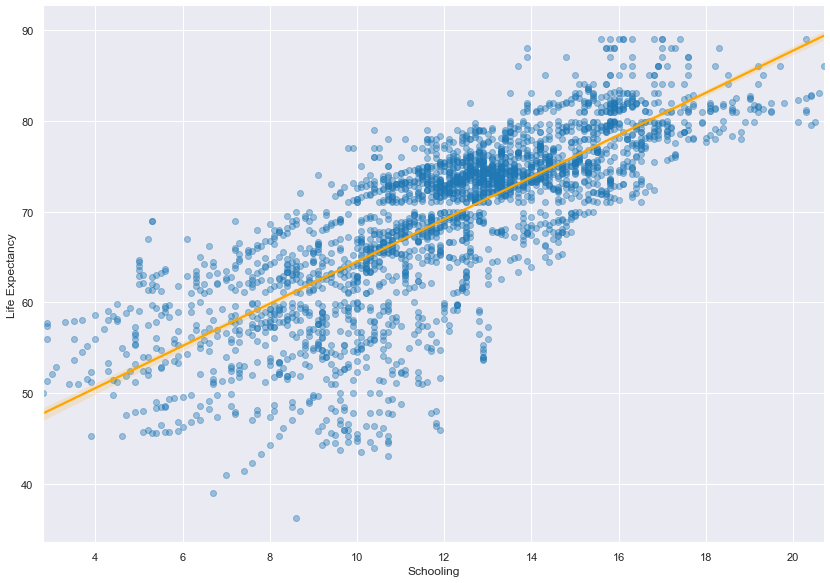

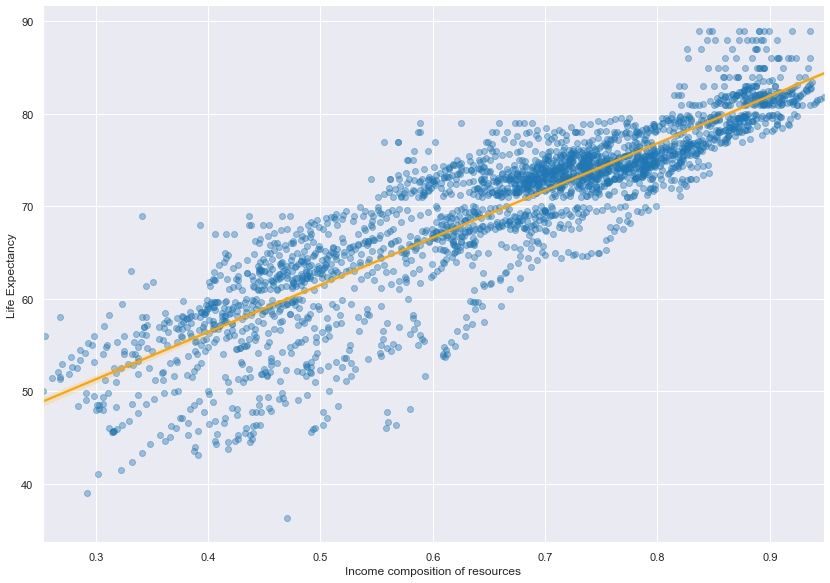

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

def LinearFit(col, LifeE, display=True, HIV_log=True):
    df = LifeE[['Year', 'Country', 'Life Expectancy', col]]
    df = df.dropna(axis=0, how='any').reset_index()  
    df = df[df[col] != 0]
    df['Life Expectancy log'] = np.log(df['Life Expectancy'])
    
    
    name_y = 'Life Expectancy'
    name_x = col

    if col == 'HIV/AIDS' and HIV_log == True:
        df[col+' log'] = np.log(df[col])      
        name_x = col+' log'
        name_y = 'Life Expectancy log'

    X = df[[name_x]]
    y = df[[name_y]]
    Xy = df[[name_y, name_x]] 
    
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    r2 = regr.score(X, y)
    
    if display == True:
        sns_plot = sns.lmplot(data=Xy, x=name_x, y=name_y, line_kws={'color': 'orange'}, 
                              scatter_kws={'color': '#1f77b4', 'alpha':0.4},
                              height=8.27, aspect=11.7/8.27)
        plt.show()
          
    return r2

dep_var = ['Schooling','Income composition of resources','HIV/AIDS']
for col in dep_var[:2]:
    LinearFit(col, LifeE)

### Transform Non-Linear Relationships <a class="anchor" id="section_1_2"></a>

When a line is not the best fit to the data, we need to transform it in order to use MLR. Looking at our plot on HIV/AIDS versus Life Expectancy below, we can see that a line is not the best fit to the data. This is also reflected in the [*coefficient of determination*](#section_3_2_1) R<sup>2</sup>. We need some intuition at this stage to choose the right curve for our data sample. The curve below looks like a power law: $$y = ax^b$$  

where $a$ and $b$ are constants. Taking the logarithm of both sides we have: 

$$log(y) = log(ax^b)$$ 
$$log(y) = log(a) + b*log(x)$$ 
$$log(y) = b*log(x) + C$$  
    
Here we have the equation of a straight line between variables `log(y)` and `log(x)`. So let's plot `log(Life Expectancy)` against `log(HIV/AIDS)`... And voilà! We now have another linear correlation to plug into our model.

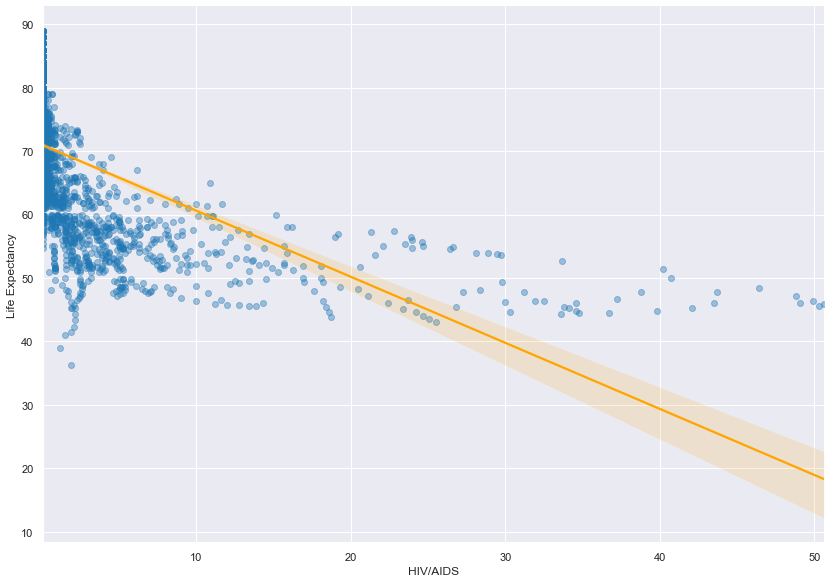

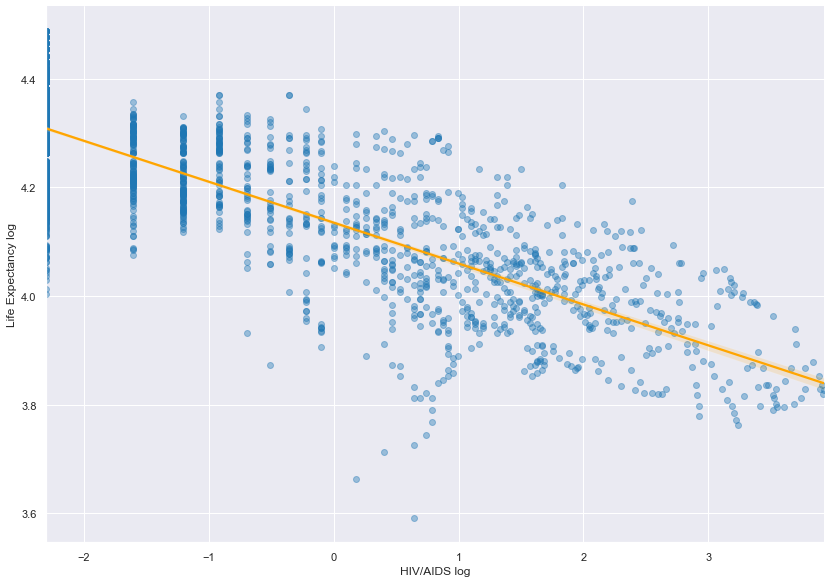

In [23]:
r2_nolog = LinearFit('HIV/AIDS', LifeE, HIV_log=False)
r2_log = LinearFit('HIV/AIDS', LifeE)

## Multiple Linear Regression Model <a class="anchor" id="chapter2"></a>


### MLR Equation <a class="anchor" id="section_2_1"></a>

The equation for multiple linear regression using $n$ number of feature variables $x$ is:

$$y = C + m_1x_1 + m_2x_2 + ..... + m_nx_n$$

where C is the intercept and $m_1, m_2,.. m_n$ are the coefficients. In our case, two of our feature variables follow linear laws and one follows a log-log law. Therefore our modified equation predicting our target variable, y, has the following form:

$$log(y) = C + m_1x_1 + m_2x_2 + m_3log(x_3)$$

<!-- 
Replacing our chosen feature variables 'Schooling', 'Income composition of resources' and log('HIV/AIDS') into the equation, we have:

$$log(Life\space Expectancy) = C + m_1(Schooling) + m_2(Income\space composition\space of\space resources) + m_3log('HIV/AIDS')$$
-->

Let's visualise this in 3 dimensions. As an example, we will plot `log(Life Expectancy)` against `Schooling` and `log(HIV/AIDS)` below. The MLR model finds the best 2D plane that fits the data. For a given (`Schooling`,`log(HIV/AIDS)`) pair, the model will find the corresponding value of `log(Life Expectancy)` that lies on the fitted 2D surface.

<img src="3D_Scatter.jpeg">

### Build a Model <a class="anchor" id="section_2_2"></a>

#### Create Data Frame Inputs
First we need to **create two data frames** - one containing the feature variables and the other the target variable. The function below first creates a data frame with all variables, drops any rows containing `NaN` values, calculates the logarithm values and splits the data into two data frames for our y and x inputs.

In [6]:
def Model_DF_X(LifeE, all=False):
    sel_cols = []
    if all == True:
        sel_cols = ['Life Expectancy'] + LifeE.columns.tolist()[4:22]
    if all == False:
        sel_cols = ['Life Expectancy','Schooling','Income composition of resources', 'HIV/AIDS'] 
    model_df_x = LifeE[sel_cols]
    model_df_x = model_df_x.dropna(axis=0, how='any').reset_index(drop=True)
    model_df_x['Life Expectancy log'] = np.log(model_df_x['Life Expectancy'])
    model_df_x['HIV/AIDS log'] = np.log(model_df_x['HIV/AIDS'])
    model_df_y = model_df_x[['Life Expectancy log']]
    model_df_x = model_df_x.drop(['Life Expectancy', 'Life Expectancy log', 'HIV/AIDS'], axis=1)
    
    return model_df_x, model_df_y

#### Split Data into Train and Test
Now that we have our feature and target data frames, which data do we fill it with? Before going any further, we need to split our data into training and testing subsets. The training subset will be used to tweak our model, for example to find the best features. We will leave the testing subset untouched until the very end when we are happy with the final parameters of our model and we want to test its performance. 

It is important to keep training and testing data separate. Effects can arise between the training data and the model, such as *overtraining*, where the best fit model is skewed by noise patterns in that specific training sample. We want to check that our model truly is unbiased to the data sample by testing it on unbiased and unseen data. 

In [7]:
from sklearn.model_selection import train_test_split

model_df_x, model_df_y = Model_DF_X(LifeE, all=False)
x_train, x_test, y_train, y_test = train_test_split(model_df_x, model_df_y, train_size=0.8, test_size=0.2)

#### Fit

Let's make an initial fit of the training data with all the variables available to us from the original dataset. For MLR, we will use `LinearRegression()` and feed it more than one feature variable in the `x_train` data frame.

In [8]:
mlr = linear_model.LinearRegression()
model = mlr.fit(x_train, y_train)

### Choose Feature Variables  <a class="anchor" id="section_2_3"></a>

At the moment, all we are interested in is seeing which variables correlate strongly with Life Expectancy. We can do this by printing a summary of the p-values of the feature variables. The p-value gives us the probability that the null hypothesis is true, the null hypothesis being that there is no correlation between the two variables. To find statistically significant correlations, we can find features with a p-value of p<0.05.

Here is a summary of the fit statistics, obtained using `statsmodels`. As we can see, `Schooling`, `Income composition of resources` and `HIV/AIDS log` all have low p-values and should be included in the model. We will stick to these three parameters here, but if you wanted to improve the accuracy of the model, you could also try including more parameters. In general, we don't want too many parameters compared to our sample size, as that could introduce unwanted *overtraining* effects. If there are parameters that don't contribute to the overall fit, they should be removed.

In [9]:
import statsmodels.api as sm

model_df_x_all, model_df_y_all = Model_DF_X(LifeE, all=True)
x_tr, x_te, y_tr, y_te = train_test_split(model_df_x_all, model_df_y_all, train_size=0.8, test_size=0.2)
est = sm.OLS(y_tr, sm.add_constant(x_tr))
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     Life Expectancy log   R-squared:                       0.843
Model:                             OLS   Adj. R-squared:                  0.841
Method:                  Least Squares   F-statistic:                     388.2
Date:                 Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                         12:59:05   Log-Likelihood:                 2006.1
No. Observations:                 1319   AIC:                            -3974.
Df Residuals:                     1300   BIC:                            -3876.
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


Running the fit again with just our three feature variables, we find the p-values below.

In [10]:
est_ols = sm.OLS(y_train, sm.add_constant(x_train))
est_fit = est_ols.fit()
p_values = est_fit.summary2().tables[1]['P>|t|']
print(p_values)

const                              0.000000e+00
Schooling                          7.650100e-57
Income composition of resources    1.569247e-35
HIV/AIDS log                       0.000000e+00
Name: P>|t|, dtype: float64


After tweaking our model by choosing the most important features, we find an R<sup>2</sup> value of 0.81. The model seems to work well, however, we still need to test it on unseen data to be sure we can believe the results.

In [11]:
score_train = mlr.score(x_train, y_train) 
print('Train score: {}'.format(score_train))

Train score: 0.8074510102748813


## Model Evaluation <a class="anchor" id="chapter3"></a>

In this section, we will evaluate the validity of the model by performing some sanity checks and we will measure its performance accuracy. Here, we use the test sample data that has been untouched until now, to give an unbiased assessment of how well the model performs.

### Model Validation <a class="anchor" id="section_3_1"></a>

To be sure the model can be believed, we have to reproduce results from data, where we already know the answer. Below are the first five predictions of the test sample compared with observed values. The predictions seem mostly reasonable but let's look at the overall trend of predicted and observed values.

| Predicted Life Expectancy | Observed Life Expectancy |
| --- | --- |
| 77.5 | 75.7 |
| 77.0 | 64.1 |
| 51.6 | 54.3 |
| 73.0 | 74.7 |
| 74.5 | 72.0 |

We will use our test sample to plot the true value of `log(Life Expectancy)` against the predicted value of `log(Life Expectancy)`. We can find the predicted `log(Life Expectancy)` values by using the `.predict` method. The plot below shows a strong linear correlation between the predicted and observed values of the test dataset, indicating that our model is working well.

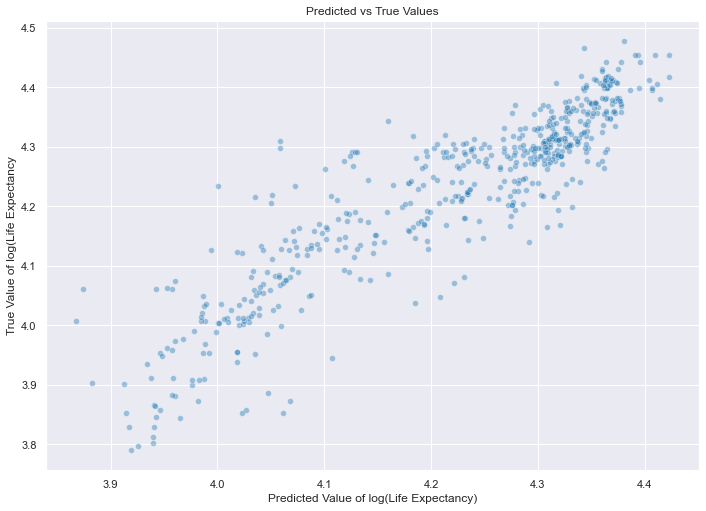

In [12]:
y_predict = mlr.predict(x_test)
y_predict_df = pd.DataFrame()
y_predict_df['Life Expectancy log'] = y_predict[:,0]
y_predict_df['Life Expectancy'] = (math.e)**y_predict_df['Life Expectancy log']
xy = pd.DataFrame()
xy['y_test'] = y_test['Life Expectancy log']
xy['y_predict'] = y_predict[:,0]

plt.figure()
pred_plot = sns.scatterplot(data=xy, x='y_predict', y='y_test', color='#1f77b4', alpha=0.4)
plt.title('Predicted vs True Values')
plt.xlabel('Predicted Value of log(Life Expectancy)')
plt.ylabel('True Value of log(Life Expectancy')
plt.show()

Our second sanity check will be to plot the residuals $(y_{true} - y_{predict})$ against the predicted values of our target, `log(Life Expectancy)`. If we have a good model, we expect to see the residuals symmetrically distributed around `Residual`=0. A point lying above or below the horizontal axis at `Residual`=0 is either overestimated or underestimated respectively.

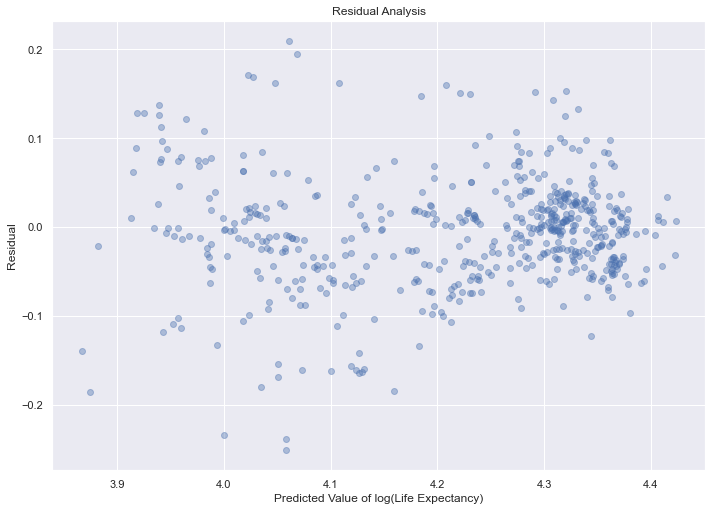

In [13]:
residuals = y_predict - y_test
plt.figure()
plt.scatter(y_predict[:,0], residuals, alpha=0.4)
plt.title('Residual Analysis')
plt.xlabel('Predicted Value of log(Life Expectancy)')
plt.ylabel('Residual')
plt.show()

### Model Performance <a class="anchor" id="section_3_2"></a>

#### Coefficient of Determination: R<sup>2</sup> <a class="anchor" id="section_3_2_1"></a>

We can quantify how good the fit is by finding its coefficient of determination R<sup>2</sup>. R<sup>2</sup> is defined as:

$$  R^2 = \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y}_i)^2} $$

where $\hat{y}$ is the predicted value and $\bar{y}$ is the average observed value.  R<sup>2</sup> is the ratio of the explained variance of the model over the total variance of the dataset. R<sup>2</sup> falls between 0 and 1, with a ratio of 1 meaning the model is perfectly accurate and explains 100% of the variation in the data. An R<sup>2</sup> value of 0 is not accurate at all and explains 0% of the data. 

#### R<sup>2</sup> of Model

Finally, we test our model on the test dataset we put away before training and tweaking our model. This test on the unseen data set will give us our model accuracy in terms of the coefficient of determination, R<sup>2</sup>. Our test score comes out to be R<sup>2</sup>=0.81, meaning our model successfully reproduces 81% of the variation seen in this unbiased dataset. 

In [14]:
score_test = mlr.score(x_test, y_test)
print('Test score: {}'.format(score_test))

Test score: 0.8176409639491673


## Making a Prediction <a class="anchor" id="chapter4"></a>

Now that we have built our model, tweaked it, validated and tested it, we can use it to predict the life expectancy of a person based on three parameters: the number of years they went to school, the human development index of their country and the child death rate due to HIV/AIDS in their location. Person 1 and Person 2 have both have typical values of `Income composition of resources` and `HIV/AIDS` for Germany but they have different education levels. Person 3 has values typical for someone living in Sierra Leone and who has primary school education.

| Feature | Description | Person 1 | Person 2 | Person 3 |
| --- | --- | --- | --- | --- |
| `Schooling` | Years of schooling | 18 | 9 | 6 |
| `Income composition of resources` | 'Human Development Index' | 0.94 | 0.94 | 0.44 |
| `log(HIV/AIDS)`| Log of AIDS child death rate | log(0.1) | log(0.1) | log(0.5) |

In [15]:
sel_cols = ['Life Expectancy','Schooling','Income composition of resources', 'HIV/AIDS']
df_query = pd.DataFrame(columns=sel_cols[1:])
df_query.loc[0] = [18.0, 0.94, np.log(0.1)]  
df_query.loc[1] = [9, 0.94, np.log(0.1)]   
df_query.loc[2] = [9, 0.44, np.log(0.5)]   
for i in range(3):
    y_query = mlr.predict(df_query)
    print('Predicted life expectancy for person {}: {}'.format(i+1, math.e**y_query[i,0]))

Predicted life expectancy for person 1: 81.13064897781548
Predicted life expectancy for person 2: 73.16500965849653
Predicted life expectancy for person 3: 62.7843114584477


Given the current income composition of resources and HIV/AIDS child death rate in Germany, a person with 18 years of schooling should have a life expectancy of 81 years. This is the current life expectancy of Germany <a href="http://hdr.undp.org/en/countries/profiles/DEU" target="_blank">according to the UN</a>, where 18 years of schooling is now 'expected' in Germany (number of years a baby born in 2020 is expected to receive). However, someone with just 9 years of schooling is predicted to have a life expectancy of 74 years. This lower figure is perhaps not surprising as there have been numerous <a href="https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/healthinequalities/articles/healthrelatedlifestylesandwidercharacteristicsofpeoplelivinginareaswiththehighestorlowesthealthylife/june2017" target="_blank">studies linking education and health</a>. Similarly, a person living in Sierra Leone completing 9 years of education is expected to have 63 years of life according to this model.

We have built a model to predict the life expectancy of a person based on features of their country of residence and their education level. When considering these predictions on life expectancy, it is important to keep in mind that the model assumes the features will have a constant value throughout a baby's life. In reality, two of these three features will change over a person's lifetime.  